In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/Shareddrives/Phân tích dữ liệu với Python/Cuối kỳ/scanner_data.csv')

In [4]:
df.drop('Unnamed: 0', inplace=True, axis = 1)

In [5]:
df.duplicated().sum()

0

In [6]:
df.isnull().sum()

Date              0
Customer_ID       0
Transaction_ID    0
SKU_Category      0
SKU               0
Quantity          0
Sales_Amount      0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Date            131706 non-null  object 
 1   Customer_ID     131706 non-null  int64  
 2   Transaction_ID  131706 non-null  int64  
 3   SKU_Category    131706 non-null  object 
 4   SKU             131706 non-null  object 
 5   Quantity        131706 non-null  float64
 6   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 7.0+ MB


In [8]:
df.describe()

,Customer_ID,Transaction_ID,Quantity,Sales_Amount
count,131706.000000,131706.000000,131706.000000,131706.000000
mean,12386.450367,32389.604187,1.485311,11.981524
std,6086.447552,18709.901238,3.872667,19.359699
min,1.000000,1.000000,0.010000,0.020000
25%,7349.000000,16134.000000,1.000000,4.230000
50%,13496.000000,32620.000000,1.000000,6.920000
75%,17306.000000,48548.000000,1.000000,12.330000
max,22625.000000,64682.000000,400.000000,707.730000


In [9]:
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
df_group_trans = df.groupby(['Date','Customer_ID','Transaction_ID']).Sales_Amount.sum().reset_index()
df_group_trans.sort_values(by=['Transaction_ID']).head(10)  

,Date,Customer_ID,Transaction_ID,Sales_Amount
4962,2016-02-01,2547,1,3.13
4935,2016-02-01,822,2,5.46
4981,2016-02-01,3686,3,6.35
4983,2016-02-01,3719,4,5.59
5063,2016-02-01,9200,5,6.88
5008,2016-02-01,5010,6,10.77
4948,2016-02-01,1666,7,11.86
4940,2016-02-01,1253,8,8.25
5016,2016-02-01,5541,9,14.53
5047,2016-02-01,7548,10,7.49


In [11]:
print('Min:{}; Max:{}'.format(min(df_group_trans.Date),max(df_group_trans.Date)))

Min:2016-01-02 00:00:00; Max:2016-12-31 00:00:00


In [12]:
#Create date called snapshot that is after max date in data 1 days to caculate Recency
snapshot_day = max(df_group_trans.Date) + datetime.timedelta(days=1)

In [13]:
df_RFM = df_group_trans.groupby('Customer_ID').agg({
    'Date': lambda x:(snapshot_day - x.max()).days,
    'Transaction_ID' : 'count',
    'Sales_Amount':'sum'
})

df_RFM.rename(columns = {'Date':'Recency',
                          'Transaction_ID':'Frequency',
                          'Sales_Amount':'Monetary'}, inplace=True)

df_RFM.head()

,Recency,Frequency,Monetary
Customer_ID,,,
1,345,1,16.29
2,196,2,22.77
3,335,1,10.92
4,55,2,33.29
5,121,5,78.82


In [14]:
df_RFM.describe(percentiles=[0.25,0.5,0.75,0.95])

,Recency,Frequency,Monetary
count,22625.000000,22625.000000,22625.000000
mean,145.408796,2.858873,69.747563
std,109.263227,4.000157,152.307769
min,1.000000,1.000000,0.140000
25%,45.000000,1.000000,10.170000
50%,121.000000,1.000000,23.850000
75%,243.000000,3.000000,63.070000
95%,336.000000,9.000000,287.256000
max,365.000000,99.000000,3985.940000


Text(0.5, 1.0, 'Boxplot of Recency')

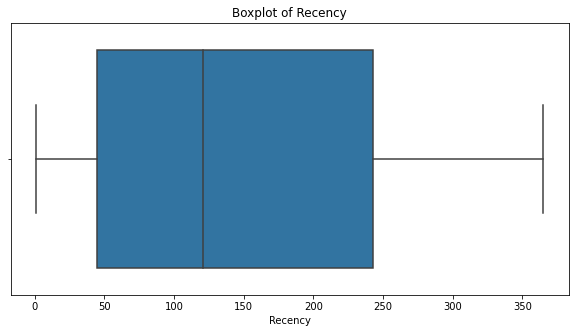

In [15]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Recency', data=df_RFM)
plt.title('Boxplot of Recency')

Text(0.5, 1.0, 'Boxplot of Frequency')

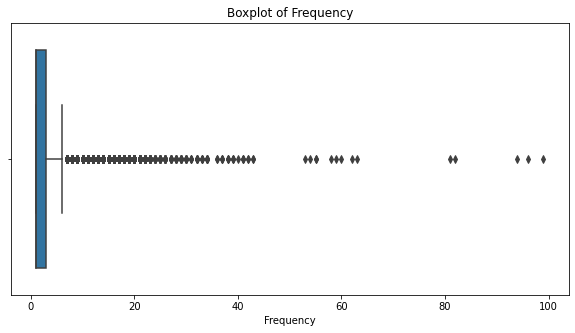

In [16]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Frequency', data=df_RFM)
plt.title('Boxplot of Frequency')

Text(0.5, 1.0, 'Boxplot of Monetary')

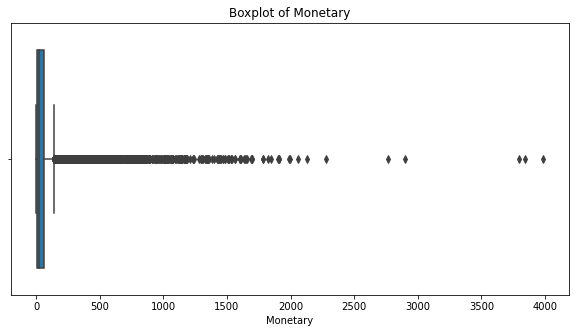

In [17]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Monetary', data=df_RFM)
plt.title('Boxplot of Monetary')

The RFM values can be grouped in several ways:

1.Percentiles e.g. quantiles

2.Pareto 80/20 cut

3.Custom - based on business knowledge

We are going to implement percentile-based grouping.

In [18]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 5
    elif x <= d[p][0.50]:
        return 4
    elif x <= d[p][0.75]: 
        return 3
    elif x <= d[p][0.95]:
        return 2
    else:
        return 1    

def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    elif x <= d[p][0.95]: 
        return 4    
    else:
        return 5

In [19]:
quantile = df_RFM.quantile(q=[0.25,0.5,0.75,0.95])
quantile

,Recency,Frequency,Monetary
0.25,45.0,1.0,10.170
0.50,121.0,1.0,23.850
0.75,243.0,3.0,63.070
0.95,336.0,9.0,287.256


In [20]:
df_RFM['R'] = df_RFM['Recency'].apply(RScore,args=('Recency',quantile))
df_RFM['F'] = df_RFM['Frequency'].apply(FMScore, args=('Frequency',quantile))
df_RFM['M'] = df_RFM['Monetary'].apply(FMScore, args=('Monetary',quantile))

In [21]:
df_RFM

,Recency,Frequency,Monetary,R,F,M
Customer_ID,,,,,,
1,345,1,16.29,1,1,2
2,196,2,22.77,3,3,2
3,335,1,10.92,2,1,2
4,55,2,33.29,4,3,3
5,121,5,78.82,4,4,4
...,...,...,...,...,...,...
22621,81,1,9.69,4,1,1
22622,16,1,6.07,5,1,1
22623,11,1,128.01,5,1,4


In [22]:
df_RFM['RFM_Segment'] = df_RFM.R.map(str) \
                            + df_RFM.F.map(str) \
                            + df_RFM.M.map(str)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment
Customer_ID,,,,,,,
1,345,1,16.29,1,1,2,112
2,196,2,22.77,3,3,2,332
3,335,1,10.92,2,1,2,212
4,55,2,33.29,4,3,3,433
5,121,5,78.82,4,4,4,444


In [23]:
df_RFM['RFM_Score'] = df_RFM['R'] + df_RFM['F'] + df_RFM['M']

In [24]:
df_RFM.sort_values(by=['RFM_Score'], ascending=False)

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
Customer_ID,,,,,,,,
7780,23,10,563.40,5,5,5,555,15
17509,16,15,495.35,5,5,5,555,15
17470,4,31,811.57,5,5,5,555,15
17471,17,62,3985.94,5,5,5,555,15
17477,9,14,870.60,5,5,5,555,15
...,...,...,...,...,...,...,...,...
1433,351,1,9.73,1,1,1,111,3
1430,348,1,7.56,1,1,1,111,3
1426,346,1,7.43,1,1,1,111,3


In [25]:
df_RFM.describe([0.25, 0.5, 0.75, 0.90])

,Recency,Frequency,Monetary,R,F,M,RFM_Score
count,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000
mean,145.408796,2.858873,69.747563,3.458696,2.241238,2.549967,8.249901
std,109.263227,4.000157,152.307769,1.201161,1.349789,1.203222,3.068806
min,1.000000,1.000000,0.140000,1.000000,1.000000,1.000000,3.000000
25%,45.000000,1.000000,10.170000,3.000000,1.000000,1.000000,6.000000
50%,121.000000,1.000000,23.850000,4.000000,1.000000,2.000000,8.000000
75%,243.000000,3.000000,63.070000,5.000000,3.000000,3.000000,11.000000
90%,311.000000,6.000000,163.660000,5.000000,4.000000,4.000000,13.000000
max,365.000000,99.000000,3985.940000,5.000000,5.000000,5.000000,15.000000


In [26]:
seg_map = {
    r'[1-3][1-3][1-5]': 'Bad Customers',
    r'3[4-5][1-5]': 'Almost Lost',
    r'[4-5][4-5][1-5]': 'Loyal Customers',
    r'[3-5][2-5]5': 'Big Spenders',
    r'[4-5][1-2][1-5]': 'New Customers',
    r'[1-2][4-5][1-5]': 'Hibernating',
    r'[4-5][3-4][1-5]': 'Potential Loyalists',
}

In [27]:
df_RFM['RFM_Segment'] = df_RFM['RFM_Segment'].replace(seg_map, regex=True)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
Customer_ID,,,,,,,,
1,345,1,16.29,1,1,2,Bad Customers,4
2,196,2,22.77,3,3,2,Bad Customers,8
3,335,1,10.92,2,1,2,Bad Customers,5
4,55,2,33.29,4,3,3,Potential Loyalists,10
5,121,5,78.82,4,4,4,Loyal Customers,12


In [28]:
df_RFM['RFM_Segment'].value_counts()

Bad Customers          10479
Loyal Customers         4028
New Customers           3922
Potential Loyalists     3377
Almost Lost              571
Hibernating              203
Big Spenders              45
Name: RFM_Segment, dtype: int64

In [29]:
df_RFM

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
Customer_ID,,,,,,,,
1,345,1,16.29,1,1,2,Bad Customers,4
2,196,2,22.77,3,3,2,Bad Customers,8
3,335,1,10.92,2,1,2,Bad Customers,5
4,55,2,33.29,4,3,3,Potential Loyalists,10
5,121,5,78.82,4,4,4,Loyal Customers,12
...,...,...,...,...,...,...,...,...
22621,81,1,9.69,4,1,1,New Customers,6
22622,16,1,6.07,5,1,1,New Customers,7
22623,11,1,128.01,5,1,4,New Customers,10


In [30]:
seg_map_level = {
    r'[1-3][1-3][1-5]': 0,
    r'3[4-5][1-5]': 1,
    r'[4-5][4-5][1-5]': 2,
    r'[3-5][2-5]5': 3,
    r'[4-5][1-2][1-5]': 4,
    r'[1-2][4-5][1-5]': 5,
    r'[4-5][3-4][1-5]': 6,
}

In [31]:
df_RFM['RFM_level'] = df_RFM['R'].map(str) + df_RFM['F'].map(str) + df_RFM['M'].map(str)

In [32]:
df_RFM['RFM_level'] = df_RFM['RFM_level'].replace(seg_map_level, regex=True)

In [33]:
df_RFM

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_level
Customer_ID,,,,,,,,,
1,345,1,16.29,1,1,2,Bad Customers,4,0
2,196,2,22.77,3,3,2,Bad Customers,8,0
3,335,1,10.92,2,1,2,Bad Customers,5,0
4,55,2,33.29,4,3,3,Potential Loyalists,10,6
5,121,5,78.82,4,4,4,Loyal Customers,12,2
...,...,...,...,...,...,...,...,...,...
22621,81,1,9.69,4,1,1,New Customers,6,4
22622,16,1,6.07,5,1,1,New Customers,7,4
22623,11,1,128.01,5,1,4,New Customers,10,4


In [34]:
df_RFM['RFM_Segment'].value_counts()

Bad Customers          10479
Loyal Customers         4028
New Customers           3922
Potential Loyalists     3377
Almost Lost              571
Hibernating              203
Big Spenders              45
Name: RFM_Segment, dtype: int64

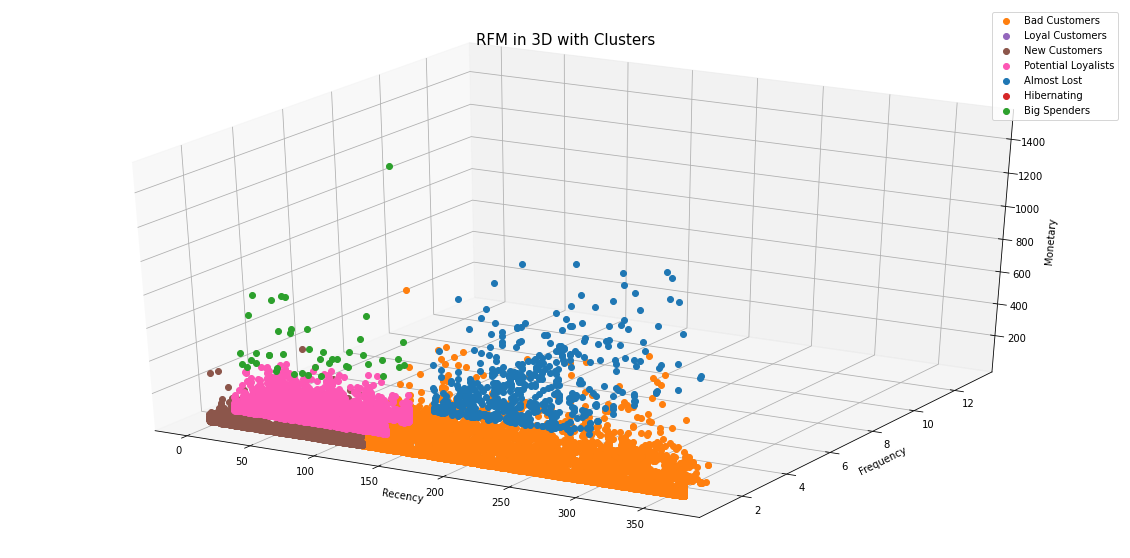

In [35]:
fig = plt.figure(figsize=(20,10))
axes = plt.subplot(111, projection='3d')
axes.plot(df_RFM[df_RFM['RFM_Segment'] == 'Bad Customers'].Recency, df_RFM[df_RFM['RFM_Segment'] == 'Bad Customers'].Frequency, df_RFM[df_RFM['RFM_Segment'] == 'Bad Customers'].Monetary, "o", c = '#ff7f0e', label="Bad Customers")
axes.plot(df_RFM[df_RFM['RFM_Segment'] == 'Loyal Customers '].Recency, df_RFM[df_RFM['RFM_Segment'] == 'Loyal Customers '].Frequency, df_RFM[df_RFM['RFM_Segment'] == 'Loyal Customers '].Monetary, "o", c = '#9467bd', label="Loyal Customers")
axes.plot(df_RFM[df_RFM['RFM_Segment'] == 'New Customers'].Recency, df_RFM[df_RFM['RFM_Segment'] == 'New Customers'].Frequency, df_RFM[df_RFM['RFM_Segment'] == 'New Customers'].Monetary, "o", c = '#8c564b' , label="New Customers")
axes.plot(df_RFM[df_RFM['RFM_Segment'] == 'Potential Loyalists'].Recency, df_RFM[df_RFM['RFM_Segment'] == 'Potential Loyalists'].Frequency, df_RFM[df_RFM['RFM_Segment'] == 'Potential Loyalists'].Monetary, "o", c = '#fd57b4' , label="Potential Loyalists")
axes.plot(df_RFM[df_RFM['RFM_Segment'] == 'Almost Lost'].Recency, df_RFM[df_RFM['RFM_Segment'] == 'Almost Lost'].Frequency, df_RFM[df_RFM['RFM_Segment'] == 'Almost Lost'].Monetary, "o", c = '#1f77b4' , label="Almost Lost")
axes.plot(df_RFM[df_RFM['RFM_Segment'] == 'Hibernating '].Recency, df_RFM[df_RFM['RFM_Segment'] == 'Hibernating '].Frequency, df_RFM[df_RFM['RFM_Segment'] == 'Hibernating '].Monetary, "o", c = '#d62728' , label="Hibernating ")
axes.plot(df_RFM[df_RFM['RFM_Segment'] == 'Big Spenders'].Recency, df_RFM[df_RFM['RFM_Segment'] == 'Big Spenders'].Frequency, df_RFM[df_RFM['RFM_Segment'] == 'Big Spenders'].Monetary, "o", c = '#2ca02c' , label="Big Spenders")


plt.xlabel('Recency')
plt.ylabel('Frequency')
axes.set_zlabel('Monetary')
plt.legend(loc="upper right")
plt.title('RFM in 3D with Clusters', size=15)
plt.show()

In [36]:
df_RFM_R = df_RFM[['RFM_Segment', 'Recency']]

In [37]:
df_RFM_R = df_RFM_R.groupby(['RFM_Segment'])['Recency'].mean()

In [38]:
df_RFM_R

RFM_Segment
Almost Lost            168.570928
Bad Customers          243.898368
Big Spenders            56.488889
Hibernating            276.650246
Loyal Customers         37.979146
New Customers           61.116012
Potential Loyalists     55.205804
Name: Recency, dtype: float64

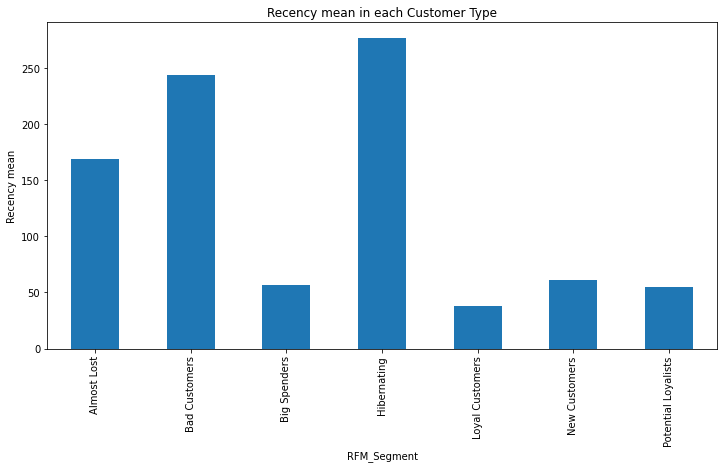

In [39]:
df_RFM_R.plot.bar(figsize = (12, 6), ylabel = 'Recency mean')
plt.title('Recency mean in each Customer Type')
plt.show()

In [40]:
df_RFM_F = df_RFM[['RFM_Segment', 'Frequency']]
df_RFM_F = df_RFM_F.groupby(['RFM_Segment'])['Frequency'].mean()

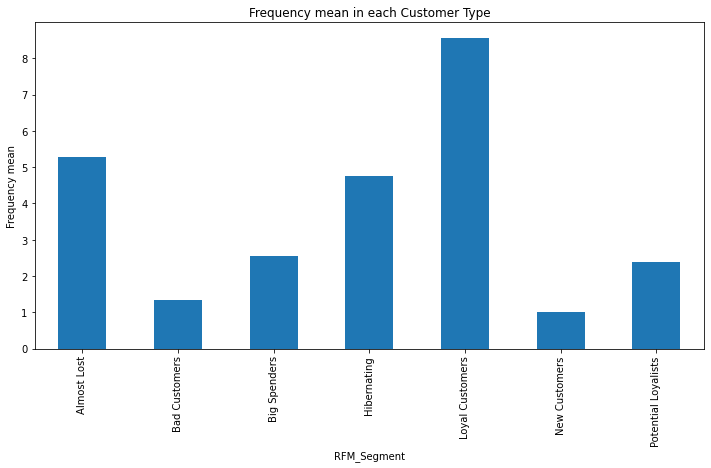

In [41]:
df_RFM_F.plot.bar(figsize = (12, 6), ylabel = 'Frequency mean')
plt.title('Frequency mean in each Customer Type')
plt.show()

In [42]:
df_RFM_M = df_RFM[['RFM_Segment', 'Monetary']]
df_RFM_M = df_RFM_M.groupby(['RFM_Segment'])['Monetary'].mean()

In [43]:
df_RFM_M


RFM_Segment
Almost Lost            130.113205
Bad Customers           28.749572
Big Spenders           435.839111
Hibernating            129.902463
Loyal Customers        228.167793
New Customers           20.075806
Potential Loyalists     46.993509
Name: Monetary, dtype: float64

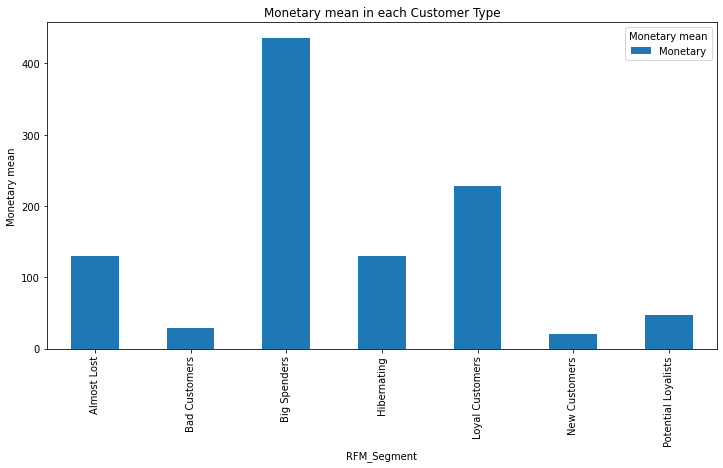

In [44]:
df_RFM_M.plot.bar(figsize = (12, 6), ylabel = 'Monetary mean')
plt.legend(title = 'Monetary mean')
plt.title('Monetary mean in each Customer Type')
plt.show()

In [45]:
segmentwise = df_RFM.groupby('RFM_Segment').agg(RecencyMean = ('Recency', 'mean'),
                                          FrequencyMean = ('Frequency', 'mean'),
                                          MonetaryMean = ('Monetary', 'mean'),
                                          GroupSize = ('Recency', 'size'))
segmentwise

,RecencyMean,FrequencyMean,MonetaryMean,GroupSize
RFM_Segment,,,,
Almost Lost,168.570928,5.283713,130.113205,571
Bad Customers,243.898368,1.348697,28.749572,10479
Big Spenders,56.488889,2.555556,435.839111,45
Hibernating,276.650246,4.768473,129.902463,203
Loyal Customers,37.979146,8.564548,228.167793,4028
New Customers,61.116012,1.000000,20.075806,3922
Potential Loyalists,55.205804,2.377554,46.993509,3377


In [ ]:
import squarify

In [ ]:
sumGroupSize = segmentwise['GroupSize'].sum()

In [ ]:
labels = [str(x) + " (" + "Total: " + str(y) + "- Ratio:" + str(round((y/sumGroupSize)*100, 2)) + "%)" for x, y in zip(segmentwise.index, segmentwise.GroupSize)]


In [ ]:
segmentwise['GroupSize']

RFM_Segment
Almost Lost              571
Bad Customers          10479
Big Spenders              45
Hibernating              203
Loyal Customers         4028
New Customers           3922
Potential Loyalists     3377
Name: GroupSize, dtype: int64

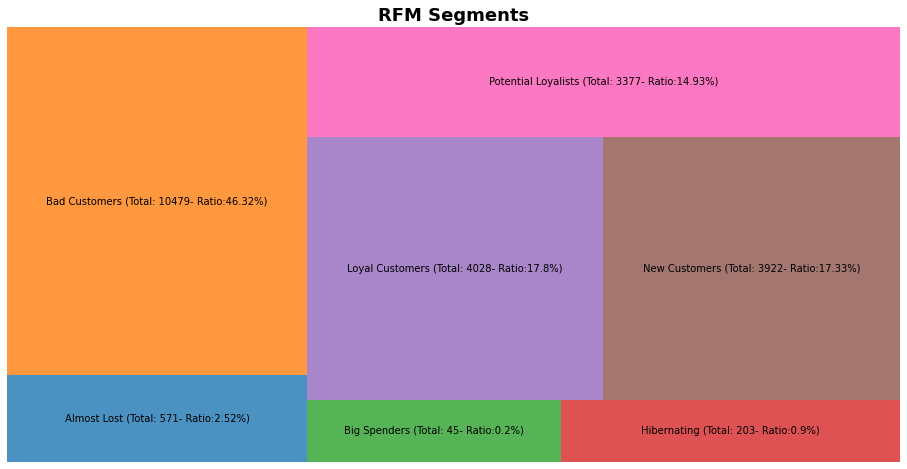

In [ ]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 8)
squarify.plot(sizes = [10, 40, 6, 8, 30, 30, 25], 
              label = labels,
              color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#fd57b4'],
              alpha = 0.8)
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

In [ ]:
df_RFM['Customer_ID'] = df_RFM.index

In [ ]:
rfm = df_RFM.groupby("RFM_Segment").agg({"Customer_ID": "nunique", 
                                        "R": "mean",
                                        "F": "mean",
                                        "M": "mean"})
rfm.rename(columns = {"Customer_ID": "Segment Size"}, inplace = True)

cm = sns.light_palette("#A2A2A2", as_cmap = True)

rfm.T.style.background_gradient(cmap = cm, axis = 1)\
.set_precision(2)\
.highlight_min(axis = 1, color = "#195190")\
.highlight_max(axis = 1, color = "#D60000")

RFM_Segment,Almost Lost,Bad Customers,Big Spenders,Hibernating,Loyal Customers,New Customers,Potential Loyalists
Segment Size,571.00,10479.00,45.00,203.00,4028.00,3922.00,3377.00
R,3.00,2.38,4.47,1.99,4.67,4.38,4.44
F,4.03,1.55,3.00,4.01,4.27,1.00,3.00
M,3.71,2.08,5.00,3.70,4.00,1.83,2.82


In [ ]:
df_RFM_CusType_Revenue = df_RFM.groupby('RFM_Segment', as_index= False)['Monetary'].sum()

In [ ]:
df_RFM_CusType_Revenue['GroupSize'] = segmentwise['GroupSize'].values

In [ ]:
df_RFM_CusType_Revenue.index = df_RFM_CusType_Revenue.RFM_Segment

In [ ]:
sum_Revenue = df_RFM_CusType_Revenue['Monetary'].sum()
sum_GroupSize = df_RFM_CusType_Revenue['GroupSize'].sum()

In [ ]:
df_RFM_CusType_Revenue['Monetary'] = df_RFM_CusType_Revenue['Monetary'].apply(lambda x: (x/sum_Revenue)*100)
df_RFM_CusType_Revenue['GroupSize'] = df_RFM_CusType_Revenue['GroupSize'].apply(lambda x: (x/sum_GroupSize)*100)

In [ ]:
df_RFM_CusType_Revenue

,RFM_Segment,Monetary,GroupSize
RFM_Segment,,,
Almost Lost,Almost Lost,4.708037,2.523757
Bad Customers,Bad Customers,19.091216,46.316022
Big Spenders,Big Spenders,1.242857,0.198895
Hibernating,Hibernating,1.671074,0.897238
Loyal Customers,Loyal Customers,58.240645,17.803315
New Customers,New Customers,4.989568,17.334807
Potential Loyalists,Potential Loyalists,10.056603,14.925967


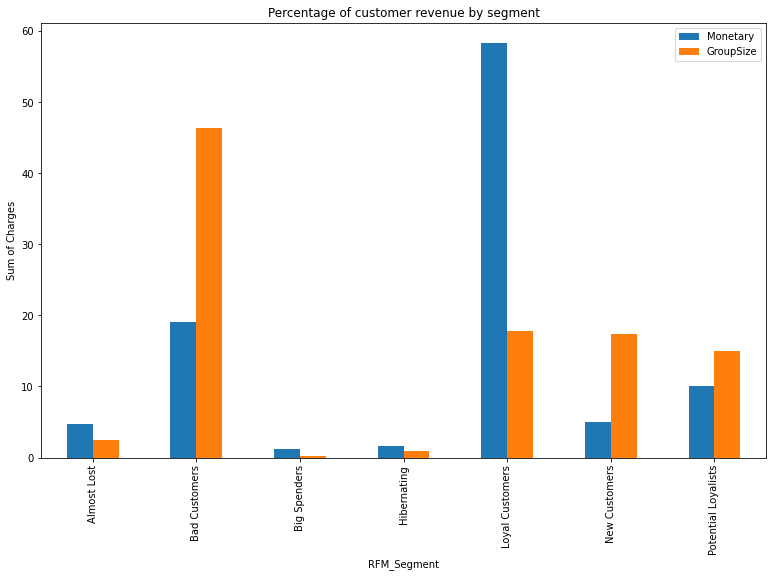

In [ ]:
fig1, axes1=plt.subplots(1,1,figsize=(13, 8))
ax = df_RFM_CusType_Revenue.plot(kind='bar',ax=axes1,title="Percentage of customer revenue by segment")
plt.legend(loc='upper right')
plt.ylabel('Sum of Charges')
plt.show()

K_means

In [ ]:
df_K_means = df_RFM[['Recency', 'Frequency', 'Monetary']]

Log, box cox, square root

c:\Users\admin\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\admin\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\admin\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

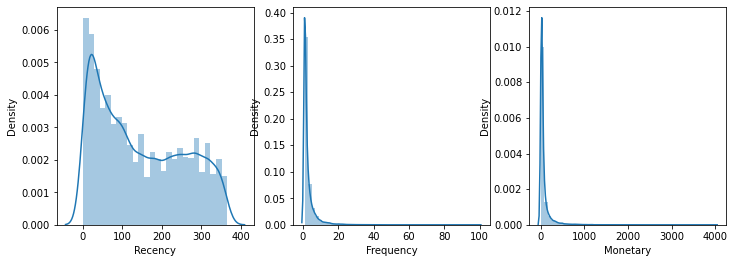

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (12,4))
sns.distplot(df_K_means['Recency'], ax = ax[0])
sns.distplot(df_K_means['Frequency'], ax = ax[1])
sns.distplot(df_K_means['Monetary'], ax = ax[2])

In [ ]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(df_K_means[x], ax=ax[0,0])
    sns.distplot(np.log(df_K_means[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(df_K_means[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(df_K_means[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(df_K_means[x].skew().round(2))
    print(np.log(df_K_means[x]).skew().round(2))
    print(np.sqrt(df_K_means[x]).skew().round(2))
    print(pd.Series(stats.boxcox(df_K_means[x])[0]).skew().round(2))

c:\Users\admin\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\admin\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\admin\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

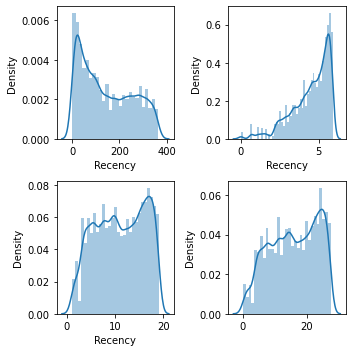

0.39
-1.11
-0.12
-0.21


In [ ]:
analyze_skewness('Recency')

c:\Users\admin\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\admin\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\admin\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

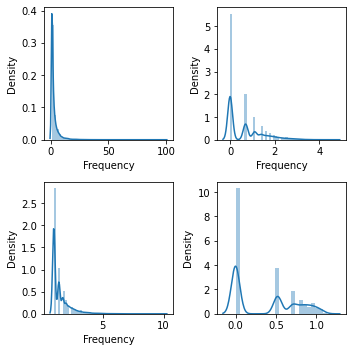

6.39
1.15
2.46
0.37


In [ ]:
analyze_skewness('Frequency')

c:\Users\admin\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\admin\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\admin\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

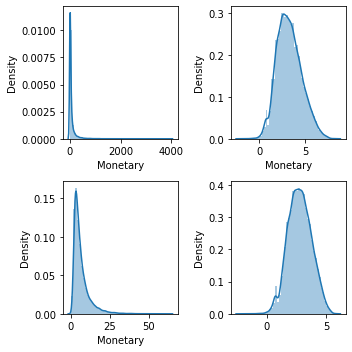

7.43
0.34
2.57
0.01


In [ ]:
analyze_skewness('Monetary')

In [ ]:
df_K_means_t = pd.DataFrame()
df_K_means_t['Recency'] = pd.Series(np.sqrt(df_K_means['Recency'])).values
df_K_means_t['Frequency'] = stats.boxcox(df_K_means['Frequency'])[0]
df_K_means_t['Monetary'] = stats.boxcox(df_K_means['Monetary'])[0]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_K_means_t = scaler.fit_transform(df_K_means_t)

In [ ]:
df_K_means_t

array([[ 1.5180613 , -0.92288563, -0.3191755 ],
       [ 0.60507906,  0.42690738, -0.05606904],
       [ 1.46393707, -0.92288563, -0.64437581],
       ...,
       [-1.52726843, -0.92288563,  1.17723583],
       [ 1.40345876, -0.92288563, -0.17283143],
       [-1.98965498,  1.16792344,  0.89130163]])

In [ ]:
df_K_means_t = pd.DataFrame(df_K_means_t)

In [ ]:
df_K_means_t.columns = df_K_means.columns[0:3]

In [ ]:
df_K_means_t.index = df_K_means.index

In [ ]:
df_K_means_t

,Recency,Frequency,Monetary
Customer_ID,,,
1,1.518061,-0.922886,-0.319175
2,0.605079,0.426907,-0.056069
3,1.463937,-0.922886,-0.644376
4,-0.709014,0.426907,0.232536
5,0.006294,1.326278,0.850700
...,...,...,...
22621,-0.392896,-0.922886,-0.743922
22622,-1.390870,-0.922886,-1.144418
22623,-1.527268,-0.922886,1.177236


c:\Users\admin\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Monetary'>

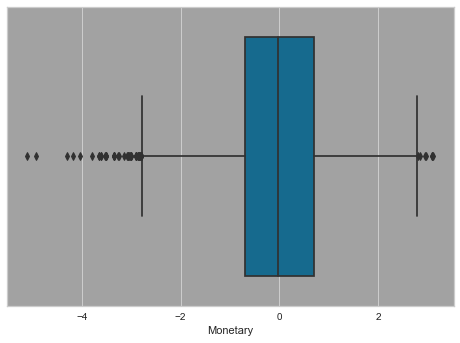

In [ ]:
sns.boxplot(df_K_means_t['Monetary'])

In [ ]:
def removeOutliers(df, column):
    Q3 = df[column].quantile(0.75)
    Q1 = df[column].quantile(0.25)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    return df[(df[column] > lower) & (df[column] < upper)], df[(df[column] <= lower) | (df[column] >= upper)].index

In [ ]:
df_K_means_t, index_outliers = removeOutliers(df_K_means_t, 'Monetary')

In [ ]:
index_outliers

Int64Index([  248,   754,  1036,  1113,  1673,  2111,  2450,  2852,  3337,
             4368,  4509,  5225,  5580,  5700,  6068,  6277,  6490,  7139,
             7568,  7677,  7743,  7800,  8627,  9015,  9659, 10304, 10517,
            10553, 10723, 10930, 11295, 13000, 13335, 14243, 14509, 14946,
            15540, 15677, 16247, 17104, 17294, 17333, 17471, 17526, 17968,
            18682, 18922, 19152, 19207, 19590, 20576, 20698, 21852, 22471,
            22618],
           dtype='int64', name='Customer_ID')

SSE of 1: 67169.39024584592
SSE of 2: 33396.859193248114
SSE of 3: 25381.406129590076
SSE of 4: 19076.669629466516
SSE of 5: 16177.263465219217
SSE of 6: 13395.094388795776
SSE of 7: 12035.394148885358
SSE of 8: 10697.060803747907
SSE of 9: 9860.133790795102
SSE of 10: 9048.579505786669


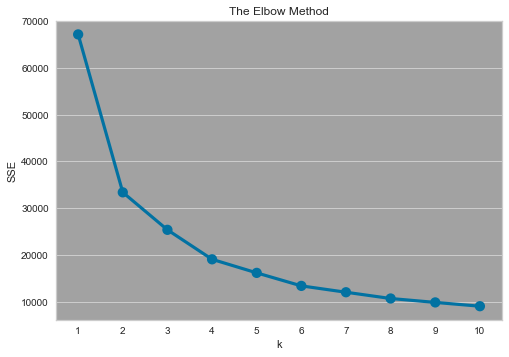

In [ ]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_K_means_t)
    sse[k] = kmeans.inertia_ 
    print(f'SSE of {k}: {sse[k]}')
    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

toc do suy giam cua ham bien dang duong nhu khong dang ke so voi trc do tu cum 3 hoac 4

In [ ]:
from sklearn.metrics import silhouette_score

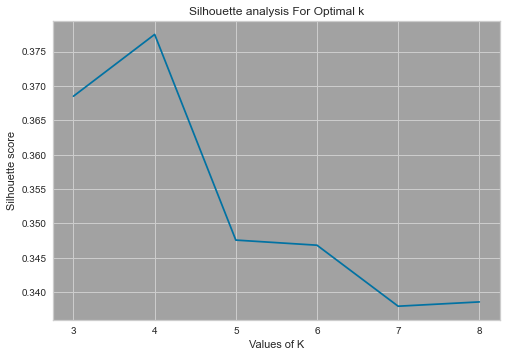

In [ ]:
range_n_clusters = [3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(df_K_means_t)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(df_K_means_t, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

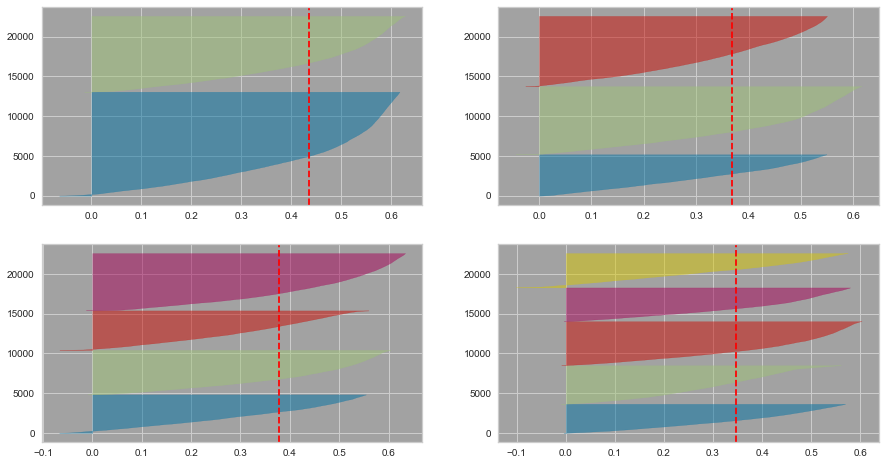

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_K_means_t)

In [ ]:
#Chon k bang 3 hoac 4

In [ ]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(df_K_means_t)

KMeans(n_clusters=4, random_state=42)

In [ ]:
df_K_means_t

,Recency,Frequency,Monetary
Customer_ID,,,
1,1.518061,-0.922886,-0.319175
2,0.605079,0.426907,-0.056069
3,1.463937,-0.922886,-0.644376
4,-0.709014,0.426907,0.232536
5,0.006294,1.326278,0.850700
...,...,...,...
22621,-0.392896,-0.922886,-0.743922
22622,-1.390870,-0.922886,-1.144418
22623,-1.527268,-0.922886,1.177236


In [ ]:
df_K_means = df_K_means[~df_K_means.index.isin(index_outliers)]

In [ ]:
df_K_means

,Recency,Frequency,Monetary
Customer_ID,,,
1,345,1,16.29
2,196,2,22.77
3,335,1,10.92
4,55,2,33.29
5,121,5,78.82
...,...,...,...
22621,81,1,9.69
22622,16,1,6.07
22623,11,1,128.01


In [ ]:
df_K_means['Cluster'] = model.labels_
df_K_means.head()

,Recency,Frequency,Monetary,Cluster
Customer_ID,,,,
1,345,1,16.29,3
2,196,2,22.77,2
3,335,1,10.92,3
4,55,2,33.29,2
5,121,5,78.82,2


In [ ]:
df_RFM = df_RFM[~df_RFM.index.isin(index_outliers)]

In [ ]:
df_RFM['Cluster'] = model.labels_
df_RFM.head()

c:\Users\admin\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_level,Customer_ID,Cluster
Customer_ID,,,,,,,,,,,
1,345,1,16.29,1,1,2,Bad Customers,4,0,1,3
2,196,2,22.77,3,3,2,Bad Customers,8,0,2,2
3,335,1,10.92,2,1,2,Bad Customers,5,0,3,3
4,55,2,33.29,4,3,3,Potential Loyalists,10,6,4,2
5,121,5,78.82,4,4,4,Loyal Customers,12,2,5,2


In [ ]:
df_RFM.groupby('Cluster').agg(
        RecencyMean = ('Recency', 'mean'),
        FrequencyMean = ('Frequency', 'mean'),
        MonetaryMean = ('Monetary', 'mean'),
        GroupSize = ('Recency', 'size')
).round(2)

,RecencyMean,FrequencyMean,MonetaryMean,GroupSize
Cluster,,,,
0,63.90,1.13,18.14,4830
1,35.94,6.83,185.87,5584
2,182.27,2.72,62.62,4958
3,259.55,1.02,16.72,7198


In [ ]:
df_K_means.groupby('Cluster').agg(
        RecencyMean = ('Recency', 'mean'),
        FrequencyMean = ('Frequency', 'mean'),
        MonetaryMean = ('Monetary', 'mean'),
        GroupSize = ('Recency', 'size')
).round(2)

,RecencyMean,FrequencyMean,MonetaryMean,GroupSize
Cluster,,,,
0,63.90,1.13,18.14,4830
1,35.94,6.83,185.87,5584
2,182.27,2.72,62.62,4958
3,259.55,1.02,16.72,7198


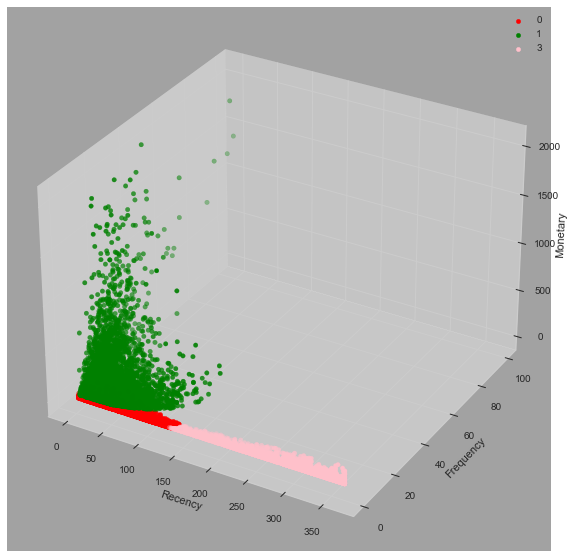

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_K_means['Recency'][df_K_means.Cluster == 0], df_K_means["Frequency"][df_K_means.Cluster == 0], df_K_means["Monetary"][df_K_means.Cluster == 0], c='red', label = '0')
ax.scatter(df_K_means['Recency'][df_K_means.Cluster == 1], df_K_means["Frequency"][df_K_means.Cluster == 1], df_K_means["Monetary"][df_K_means.Cluster == 1], c='green',  label = '1')
# ax.scatter(df_K_means['Recency'][df_K_means.Cluster == 2], df_K_means["Frequency"][df_K_means.Cluster == 2], df_K_means["Monetary"][df_K_means.Cluster == 2], c='blue',  label = '2')
ax.scatter(df_K_means['Recency'][df_K_means.Cluster == 3], df_K_means["Frequency"][df_K_means.Cluster == 3], df_K_means["Monetary"][df_K_means.Cluster == 3], c='pink',  label = '3')

plt.xlabel("Recency")
plt.ylabel("Frequency")
ax.set_zlabel('Monetary')
plt.legend()
plt.show()

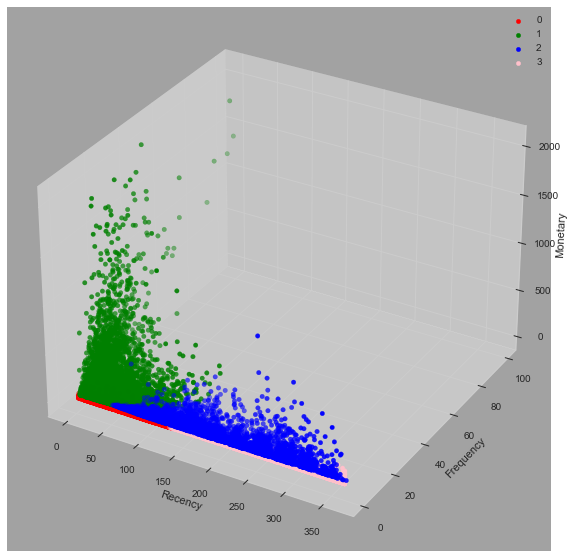

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_K_means['Recency'][df_K_means.Cluster == 0], df_K_means["Frequency"][df_K_means.Cluster == 0], df_K_means["Monetary"][df_K_means.Cluster == 0], c='red', label = '0')
ax.scatter(df_K_means['Recency'][df_K_means.Cluster == 1], df_K_means["Frequency"][df_K_means.Cluster == 1], df_K_means["Monetary"][df_K_means.Cluster == 1], c='green',  label = '1')
ax.scatter(df_K_means['Recency'][df_K_means.Cluster == 2], df_K_means["Frequency"][df_K_means.Cluster == 2], df_K_means["Monetary"][df_K_means.Cluster == 2], c='blue',  label = '2')
ax.scatter(df_K_means['Recency'][df_K_means.Cluster == 3], df_K_means["Frequency"][df_K_means.Cluster == 3], df_K_means["Monetary"][df_K_means.Cluster == 3], c='pink',  label = '3')

plt.xlabel("Recency")
plt.ylabel("Frequency")
ax.set_zlabel('Monetary')
plt.legend()
plt.show()

In [ ]:
df_RFM_CusType_Revenue = df_RFM.groupby('Cluster').agg(
        Total_Revenue = ('Monetary', 'sum'),
        GroupSize = ('Monetary', 'size')
).round(2)

In [ ]:
df_RFM_CusType_Revenue

,Total_Revenue,GroupSize
Cluster,,
0,87621.02,4830
1,1037881.49,5584
2,310456.33,4958
3,120336.05,7198


In [ ]:
sum_Revenue = df_RFM_CusType_Revenue['Total_Revenue'].sum()
sum_GroupSize = df_RFM_CusType_Revenue['GroupSize'].sum()

In [ ]:
df_RFM_CusType_Revenue['Total_Revenue'] = df_RFM_CusType_Revenue['Total_Revenue'].apply(lambda x: ((x/sum_Revenue))*100)
df_RFM_CusType_Revenue['GroupSize'] = df_RFM_CusType_Revenue['GroupSize'].apply(lambda x: ((x/sum_GroupSize))*100)

In [ ]:
df_RFM_CusType_Revenue

,Total_Revenue,GroupSize
Cluster,,
0,5.630104,21.400089
1,66.689256,24.740806
2,19.948426,21.967213
3,7.732214,31.891892


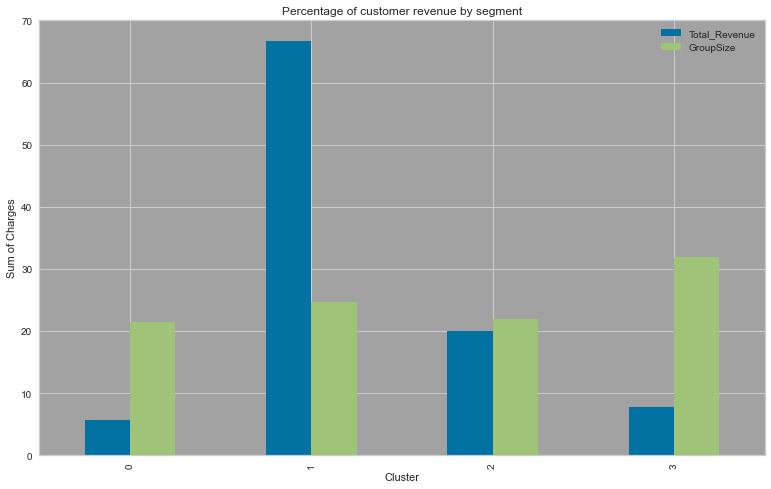

In [ ]:
fig1, axes1=plt.subplots(1,1,figsize=(13, 8))
ax = df_RFM_CusType_Revenue.plot(kind='bar',ax=axes1,title="Percentage of customer revenue by segment")
plt.legend(loc='upper right')
plt.ylabel('Sum of Charges')
plt.show()

In [ ]:
df_RFM_CusType_Revenue

,Total_Revenue,GroupSize
Cluster,,
0,87621.02,4830
1,1037881.49,5584
2,310456.33,4958
3,120336.05,7198


In [ ]:
sum_GroupSize = df_RFM_CusType_Revenue['GroupSize'].sum()

In [ ]:
labels_k_means = ['Cluster ' + str(y) + ": " +  'Total: '+ str(x) + "\nRatio" + str(round((x/sum_GroupSize)*100,2)) + "%" for x, y in zip(df_RFM_CusType_Revenue.GroupSize, df_RFM_CusType_Revenue.index)]

In [ ]:
labels_k_means

['Cluster 0: Total: 4830\nRatio21.4%',
 'Cluster 1: Total: 5584\nRatio24.74%',
 'Cluster 2: Total: 4958\nRatio21.97%',
 'Cluster 3: Total: 7198\nRatio31.89%']

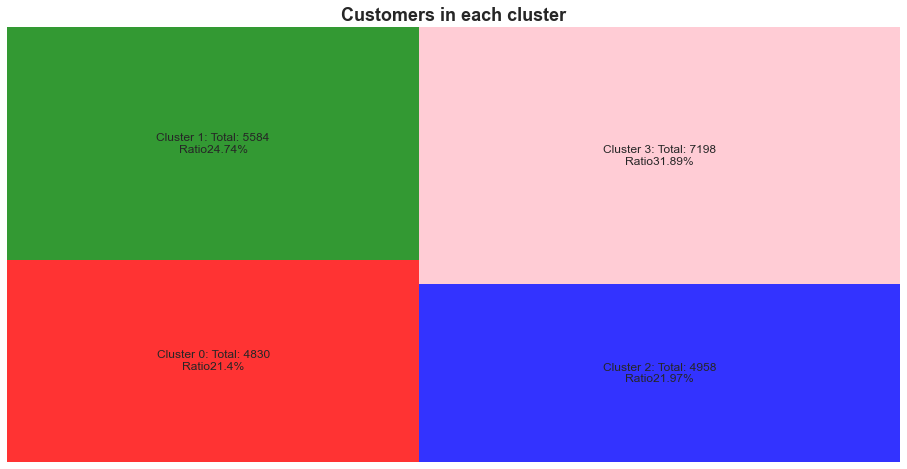

In [ ]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 8)
squarify.plot(sizes = df_RFM_CusType_Revenue['GroupSize'], 
              label = labels_k_means,
              color = ['red', 'green', 'blue', 'pink'],
              alpha = 0.8)
plt.title("Customers in each cluster",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

#Tu phan vi cua tung cum

In [ ]:
df_K_means[df_K_means['Cluster'] == 0].describe()

,Recency,Frequency,Monetary,Cluster
count,4830.000000,4830.000000,4830.000000,4830.0
mean,63.903313,1.125052,18.140998,0.0
std,38.016878,0.338240,21.536523,0.0
min,1.000000,1.000000,1.080000,0.0
25%,31.000000,1.000000,6.820000,0.0
50%,61.000000,1.000000,12.000000,0.0
75%,96.000000,1.000000,20.397500,0.0
max,143.000000,4.000000,242.750000,0.0


In [ ]:
df_K_means[df_K_means['Cluster'] == 1].describe()

,Recency,Frequency,Monetary,Cluster
count,5584.000000,5584.000000,5584.000000,5584.0
mean,35.936963,6.825036,185.867029,1.0
std,28.822282,6.217274,237.650535,0.0
min,1.000000,1.000000,8.440000,1.0
25%,13.000000,3.000000,52.347500,1.0
50%,28.000000,5.000000,100.600000,1.0
75%,54.000000,8.000000,213.812500,1.0
max,182.000000,99.000000,2057.690000,1.0


In [ ]:
df_K_means[df_K_means['Cluster'] == 2].describe()

,Recency,Frequency,Monetary,Cluster
count,4958.000000,4958.000000,4958.000000,4958.0
mean,182.266640,2.723881,62.617251,2.0
std,76.468776,1.254163,75.140102,0.0
min,47.000000,1.000000,6.410000,2.0
25%,119.000000,2.000000,22.512500,2.0
50%,174.000000,2.000000,37.680000,2.0
75%,244.000000,3.000000,70.577500,2.0
max,365.000000,13.000000,1169.970000,2.0


In [ ]:
df_K_means[df_K_means['Cluster'] == 3].describe()

,Recency,Frequency,Monetary,Cluster
count,7198.000000,7198.000000,7198.000000,7198.0
mean,259.550153,1.015838,16.717984,3.0
std,63.882190,0.124856,18.611060,0.0
min,129.000000,1.000000,1.090000,3.0
25%,209.000000,1.000000,6.130000,3.0
50%,263.000000,1.000000,10.570000,3.0
75%,315.000000,1.000000,19.617500,3.0
max,365.000000,2.000000,177.060000,3.0


Text(0.5, 1.0, 'Recency box plot in each cluster')

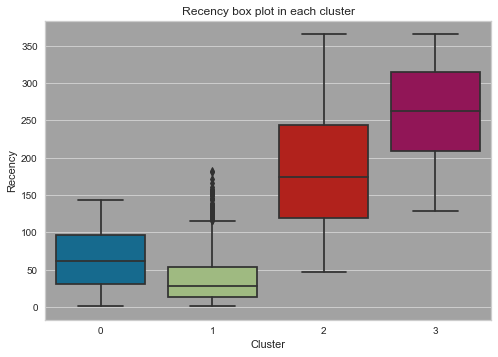

In [ ]:
sns.boxplot(x = 'Cluster', y='Recency', data=df_K_means)
plt.title('Recency box plot in each cluster')

Text(0.5, 1.0, 'Frequency box plot in each cluster')

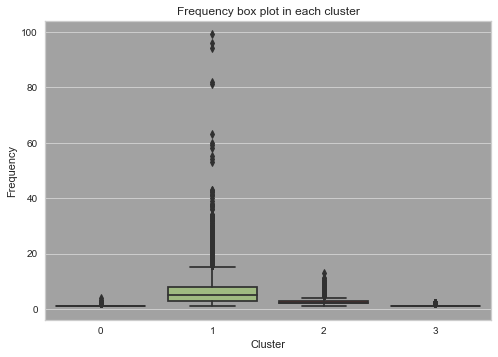

In [ ]:
sns.boxplot(x = 'Cluster', y='Frequency', data=df_K_means)
plt.title('Frequency box plot in each cluster')

Text(0.5, 1.0, 'Monetary box plot in each cluster')

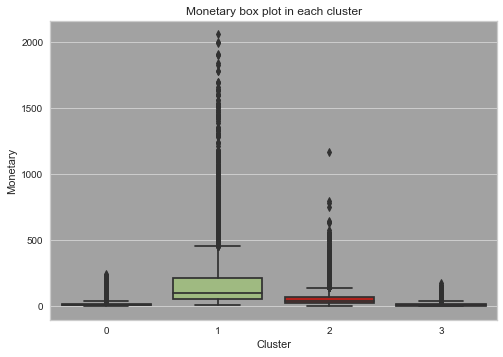

In [ ]:
sns.boxplot(x = 'Cluster', y='Monetary', data=df_K_means)
plt.title('Monetary box plot in each cluster')

Cohort analysis

In [ ]:
def get_day(x): 
    return datetime.datetime(x.year, x.month, x.day)

def get_month(x):
    return datetime.datetime(x.year, x.month, 1)

In [ ]:
df['Date']= pd.to_datetime(df['Date'])
df['invoice_date'] = df['Date'].apply(get_day)

In [ ]:
#Tạo group invoice để lấy ngày đầu tiên mua hàng của mỗi KH, có thể groupby rồi lấy min date
group_invoice = df.groupby('Customer_ID')['invoice_date']

In [ ]:
df['first_date'] = group_invoice.transform('min')

In [ ]:
df['last_date'] = group_invoice.transform('max')

In [ ]:
#Lay ra ngay dau thang
df['invoice_month'] = df['Date'].apply(get_month)

In [ ]:
group_month = df.groupby('Customer_ID')['invoice_date']

In [ ]:
#Thang dau tien mua hang, khac voi ngay dau tien mua thang
df['first_month'] = group_month.transform('min').apply(get_month)

In [ ]:
def get_ymd (df, column):
    year=df[column].dt.year
    month=df[column].dt.month
    day=df[column].dt.day
    return year, month, day

In [ ]:
invoice_year, invoice_month, _ = get_ymd(df, 'invoice_date')
first_year, first_month, _ = get_ymd(df, 'first_date')

years_diff = invoice_year - first_year
months_diff = invoice_month - first_month

In [ ]:
df['duration_month'] = years_diff * 12 + months_diff * 1 + 1
#Cong 1 vi k muon co gia tri 0, ngay invoice_date va first_date trung nhau thi ra 0 
df.head()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,invoice_date,first_date,last_date,invoice_month,first_month,duration_month
0,2016-02-01,2547,1,X52,0EM7L,1.0,3.13,2016-02-01,2016-01-25,2016-11-04,2016-02-01,2016-01-01,2
1,2016-02-01,822,2,2ML,68BRQ,1.0,5.46,2016-02-01,2016-01-30,2016-03-02,2016-02-01,2016-01-01,2
2,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35,2016-02-01,2016-01-14,2016-11-01,2016-02-01,2016-01-01,2
3,2016-02-01,3719,4,0H2,549KK,1.0,5.59,2016-02-01,2016-01-14,2016-12-01,2016-02-01,2016-01-01,2
4,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88,2016-02-01,2016-02-01,2016-09-04,2016-02-01,2016-02-01,1


In [ ]:
#Dem Customer_ID chu k phai lay ra ma Customer_ID, dem so Customer_ID trong thang do va trong khoang tg do
group_cohort = df.groupby(['first_month','duration_month'])
cohort_data = group_cohort['Customer_ID'].apply(pd.Series.nunique).reset_index()
cohort_data

,first_month,duration_month,Customer_ID
0,2016-01-01,1,3817
1,2016-01-01,2,1104
2,2016-01-01,3,971
3,2016-01-01,4,899
4,2016-01-01,5,823
...,...,...,...
73,2016-10-01,2,112
74,2016-10-01,3,134
75,2016-11-01,1,1134
76,2016-11-01,2,100


In [ ]:
cohort_counts

duration_month,1,2,3,4,5,6,7,8,9,10,11,12
first_month,,,,,,,,,,,,
2016-01-01,3817.0,1104.0,971.0,899.0,823.0,697.0,718.0,723.0,701.0,635.0,697.0,716.0
2016-02-01,2759.0,550.0,515.0,511.0,436.0,420.0,444.0,457.0,448.0,463.0,435.0,NaN
2016-03-01,2619.0,568.0,532.0,479.0,476.0,456.0,469.0,466.0,459.0,505.0,NaN,NaN
2016-04-01,2292.0,436.0,399.0,366.0,368.0,416.0,363.0,391.0,389.0,NaN,NaN,NaN
2016-05-01,2180.0,315.0,314.0,292.0,321.0,336.0,310.0,325.0,NaN,NaN,NaN,NaN
2016-06-01,1446.0,169.0,184.0,204.0,189.0,193.0,209.0,NaN,NaN,NaN,NaN,NaN
2016-07-01,1238.0,128.0,138.0,149.0,128.0,158.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-01,1249.0,137.0,119.0,117.0,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-01,1554.0,205.0,179.0,196.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cohort_counts = cohort_data.pivot(index='first_month', columns='duration_month', values='Customer_ID')
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(4)*100

duration_month,1,2,3,4,5,6,7,8,9,10,11,12
first_month,,,,,,,,,,,,
2016-01-01,100.0,28.92,25.44,23.55,21.56,18.26,18.81,18.94,18.37,16.64,18.26,18.76
2016-02-01,100.0,19.93,18.67,18.52,15.80,15.22,16.09,16.56,16.24,16.78,15.77,NaN
2016-03-01,100.0,21.69,20.31,18.29,18.17,17.41,17.91,17.79,17.53,19.28,NaN,NaN
2016-04-01,100.0,19.02,17.41,15.97,16.06,18.15,15.84,17.06,16.97,NaN,NaN,NaN
2016-05-01,100.0,14.45,14.40,13.39,14.72,15.41,14.22,14.91,NaN,NaN,NaN,NaN
2016-06-01,100.0,11.69,12.72,14.11,13.07,13.35,14.45,NaN,NaN,NaN,NaN,NaN
2016-07-01,100.0,10.34,11.15,12.04,10.34,12.76,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-01,100.0,10.97,9.53,9.37,9.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-01,100.0,13.19,11.52,12.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


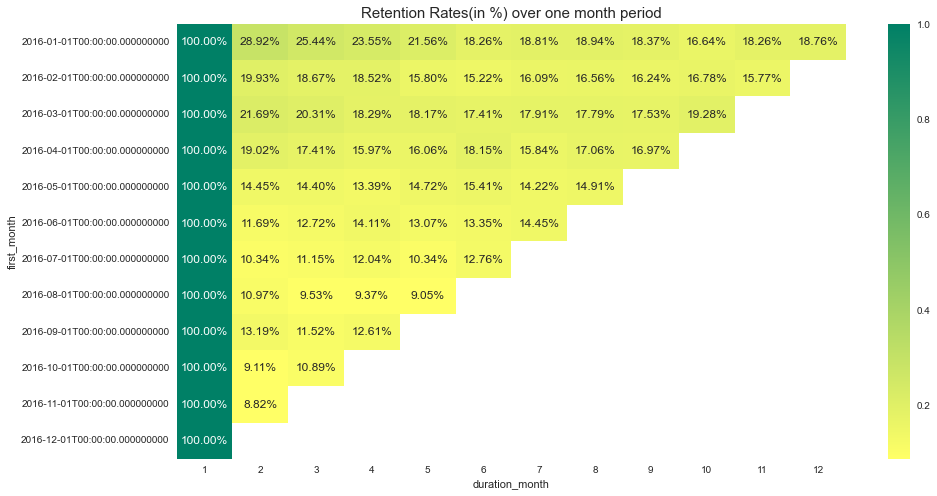

In [ ]:
plt.figure(figsize=(15, 8))
plt.title('Retention Rates(in %) over one month period', size=15)
sns.heatmap(data=retention, annot = True, fmt = '.2%', cmap="summer_r")
plt.show()

In [ ]:
customer_per_month = df.groupby("first_month")["Customer_ID"].nunique().values
customers = customer_per_month.cumsum()
customers = customers[::-1]
customers

array([22625, 21518, 20384, 19154, 17600, 16351, 15113, 13667, 11487,
        9195,  6576,  3817], dtype=int64)

In [ ]:
customer_in_month = df.groupby("duration_month")["Customer_ID"].nunique()
customer_in_month

duration_month
1     22625
2      3824
3      3485
4      3213
5      2854
6      2676
7      2513
8      2362
9      1997
10     1603
11     1132
12      716
Name: Customer_ID, dtype: int64

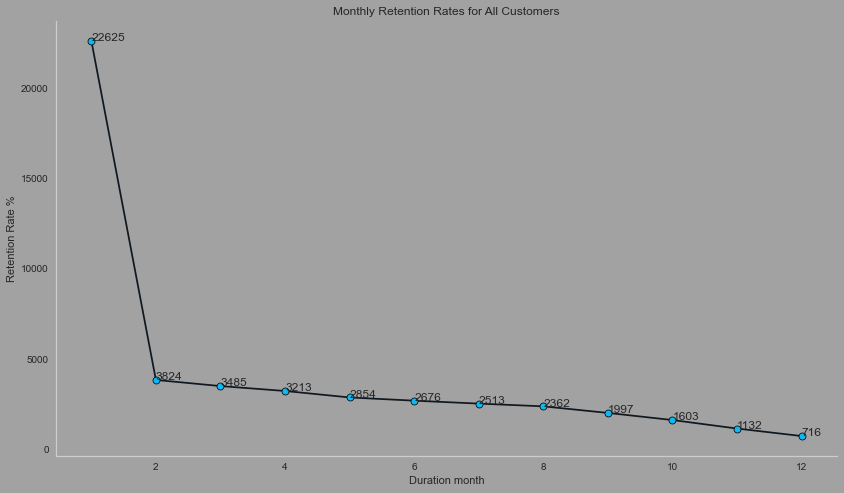

In [ ]:
plt.rcParams["axes.facecolor"] = "#A2A2A2"
fig, ax = plt.subplots(figsize = (14, 8), facecolor = "#A2A2A2")
ax.grid(False)
x = customer_in_month.index
y = customer_in_month

sns.lineplot(x = x, y = y,  color = "#101820", marker = "o", markerfacecolor = "#0EB8F1", markeredgecolor = "#000000")

for x, y in zip(x, y):
    plt.text(x, y + 2, s = str(round(y, 2)))

plt.xlabel("Duration month")
plt.ylabel("Retention Rate %")
plt.title("Customers remain in each duration")
sns.despine()
plt.show()

In [ ]:
monthly_customer_price_df = df.groupby("invoice_month").agg({"Sales_Amount": "sum",
                                                            "Customer_ID": "nunique"})

monthly_customer_price_df

,Sales_Amount,Customer_ID
invoice_month,,
2016-01-01,117284.11,3817
2016-02-01,117005.29,3863
2016-03-01,126225.65,4140
2016-04-01,134523.44,4274
2016-05-01,142155.20,4482
2016-06-01,124767.33,3772
2016-07-01,124108.75,3701
2016-08-01,128139.95,3844
2016-09-01,148277.18,4397


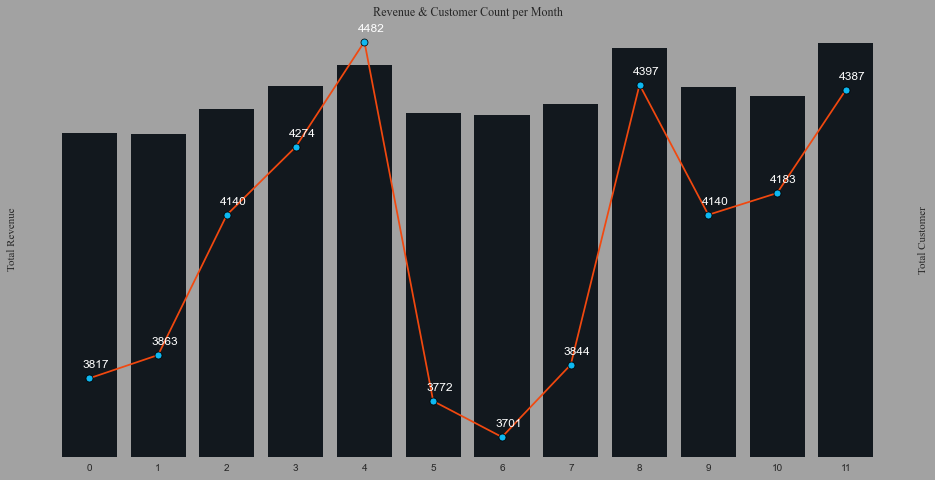

In [ ]:
fig, ax = plt.subplots(figsize = (16, 8), facecolor = "#A2A2A2")
ax.set_facecolor("#A2A2A2")

sns.barplot(x = np.arange(len(monthly_customer_price_df.index)), y = monthly_customer_price_df.Sales_Amount, ax = ax,
            color = "#101820")
ax2 = ax.twinx()
sns.lineplot(x = np.arange(len(monthly_customer_price_df.index)), y = monthly_customer_price_df.Customer_ID, ax = ax2,
            color = "#F1480F", marker = "o", markerfacecolor = "#0EB8F1", markeredgecolor = "#000000")

ax.set_yticks([])
ax2.set_yticks([])
ax2.set_ylabel("Total Customer", fontname = "Times New Roman")
ax.set_ylabel("Total Revenue", fontname = "Times New Roman")
plt.title("Revenue & Customer Count per Month", fontname = "Times New Roman")
ax.text(-0.75, 10000, "", 
        fontsize = 7, alpha = 0.8, fontname = "Times New Roman")
for x, y in zip(np.arange(len(monthly_customer_price_df.index)),  monthly_customer_price_df.Customer_ID):
    ax2.text(x -0.1, y + 20 , y, color = "white")
    
sns.despine(left = True, right = True, bottom = True, top = True)
plt.show()